In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 00:07:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 43%   47C    P8    22W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

# LDA

## 2010 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2010.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(3941 unique tokens: ['一种', '两侧', '临时', '体内', '保温']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.469953,1754.524729
1,3,-7.423433,1674.773320
2,4,-7.391572,1622.253790
3,5,-7.358397,1569.318503
4,6,-7.332053,1528.516634
5,7,-7.328759,1523.489194
6,8,-7.313336,1500.173387
7,9,-7.296609,1475.288839
8,10,-7.276405,1445.780882
9,11,-7.286276,1460.122809


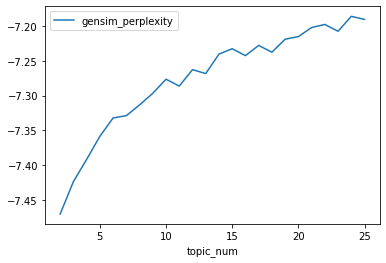

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.469953,1754.524729
1,3,-7.423433,1674.773320
2,4,-7.391572,1622.253790
3,5,-7.358397,1569.318503
4,6,-7.332053,1528.516634
5,7,-7.328759,1523.489194
6,8,-7.313336,1500.173387
7,9,-7.296609,1475.288839
8,10,-7.276405,1445.780882
9,11,-7.286276,1460.122809


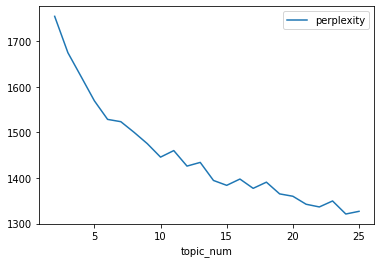

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2010.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

17

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[17,
 20,
 6,
 3,
 3,
 9,
 16,
 1,
 3,
 18,
 23,
 21,
 9,
 17,
 22,
 10,
 15,
 1,
 1,
 19,
 1,
 9,
 15,
 1,
 14,
 15,
 17,
 1,
 19,
 8,
 3,
 20,
 9,
 14,
 5,
 19,
 10,
 13,
 0,
 1,
 21,
 10,
 12,
 23,
 0,
 22,
 23,
 16,
 19,
 23,
 16,
 21,
 0,
 20,
 14,
 10,
 19,
 18,
 15,
 7,
 19,
 13,
 21,
 16,
 1,
 19,
 1,
 12,
 11,
 5,
 1,
 2,
 14,
 1,
 3,
 5,
 15,
 22,
 19,
 1,
 4,
 4,
 5,
 7,
 11,
 3,
 3,
 0,
 12,
 18,
 2,
 1,
 18,
 16,
 11,
 16,
 18,
 1,
 1,
 5,
 17,
 3,
 11,
 23,
 13,
 1,
 11,
 3,
 4,
 1,
 22,
 12,
 19,
 20,
 1,
 13,
 16,
 1,
 4,
 11,
 23,
 8,
 5,
 10,
 11,
 12,
 14,
 6,
 16,
 18,
 4,
 18,
 5,
 10,
 19,
 8,
 22,
 3,
 10,
 19,
 10,
 1,
 14,
 17,
 11,
 13,
 15,
 2,
 8,
 11,
 11,
 2,
 9,
 22,
 18,
 22,
 18,
 6,
 11,
 4,
 1,
 12,
 12,
 19,
 17,
 9,
 19,
 2,
 3,
 11,
 6,
 10,
 1,
 1,
 1,
 4,
 15,
 12,
 21,
 14,
 2,
 20,
 11,
 1,
 2,
 7,
 5,
 21,
 8,
 1,
 13,
 23,
 18,
 22,
 5,
 22,
 7,
 15,
 13,
 14,
 21,
 2,
 21,
 3,
 22,
 1,
 18,
 1,
 1,
 18,
 16,
 19,
 13,
 1,
 8,
 21,
 23,
 17,


In [25]:
print(len(topics_cn))
print(len(cn_desc))

266
266


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2010 = db.rm_patent_us_2010
    db_rm_cn_2010 = db.rm_patent_cn_2010
    # db_rm_de_2010 = db.rm_patent_de_2010
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2010.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61fd2c79f4d57576a50216cd,CN102259231A,[China Huaye Group Co Ltd],本发明提供一种回转窑筒体的高空焊接工艺，包括：装配能够使回转窑筒体实现分段转动的临时盘车措施...
1,61fd2c7ff4d57576a50216cf,CN102140507B,[Nankai Univ],本发明提供了一种关于引起人类感染性腹泻的主要病原微生物的基因芯片及检测用试剂盒，其主要针对致...
2,61fd2ca2f4d57576a50216d5,CN101892395A,"[ZHEJIANG HUAGUANG SMELTING GROUP CO Ltd, Adva...",一种微波真空分解冶炼金属镁的方法，属于金属镁冶炼领域。首先将原料镁砂、石灰与硅铁破碎后按比例...
3,61fd2ca4f4d57576a50216d7,CN101831505A,[Wuhan University WHU],本发明公开了一种检测临床常见病原微生物的基因芯片。该基因芯片包括固定在固相载体上的特异检测探...
4,61fd2ca7f4d57576a50216d9,CN102080127A,"[GUANGZHOU IMPROVE MEDICAL CO Ltd, Wuhan Unive...",本发明公开了一种检测15种临床常见病原微生物的基因芯片。该基因芯片包括固定在固相载体上的特异...
...,...,...,...,...
261,61fd5134f4d57576a5021e9b,CN102238728A,[ZTE Corp],本发明公开了一种组网方式的指示方法、频率分区的确定方法及系统，其中组网方式的指示方法包括：基...
262,61fd5135f4d57576a5021ea3,CN201863635U,[Qingte Group Co Ltd],本实用新型公开了一种具有强力齿轮的驱动车桥，包括桥壳、凸轮轴、半轴、轮毂，所述凸轮轴与半轴连...
263,61fd513cf4d57576a5021eaf,CN102335845A,[NFC Shenyang Metallurgy Machinery Co Ltd],一种磨床曲轴加工配重装置属于磨床曲轴加工配重装置的改进。本发明提供一种更适合长偏心曲轴加工、...
264,61fd513ef4d57576a5021eb9,CN102476015A,[Dalian Chuangda Technology Trade Market Co Ltd],本发明挥发性有机物回收方法及装置。所述方法最好包括利用洗涤器在水中吸收在来自排放源的废气中的...


In [30]:
print(len(df_cn))
print(len(cn_desc))

266
266


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61fd2c79f4d57576a50216cd,CN102259231A,[China Huaye Group Co Ltd],本发明提供一种回转窑筒体的高空焊接工艺，包括：装配能够使回转窑筒体实现分段转动的临时盘车措施...,17
1,61fd2c7ff4d57576a50216cf,CN102140507B,[Nankai Univ],本发明提供了一种关于引起人类感染性腹泻的主要病原微生物的基因芯片及检测用试剂盒，其主要针对致...,20
2,61fd2ca2f4d57576a50216d5,CN101892395A,"[ZHEJIANG HUAGUANG SMELTING GROUP CO Ltd, Adva...",一种微波真空分解冶炼金属镁的方法，属于金属镁冶炼领域。首先将原料镁砂、石灰与硅铁破碎后按比例...,6
3,61fd2ca4f4d57576a50216d7,CN101831505A,[Wuhan University WHU],本发明公开了一种检测临床常见病原微生物的基因芯片。该基因芯片包括固定在固相载体上的特异检测探...,3
4,61fd2ca7f4d57576a50216d9,CN102080127A,"[GUANGZHOU IMPROVE MEDICAL CO Ltd, Wuhan Unive...",本发明公开了一种检测15种临床常见病原微生物的基因芯片。该基因芯片包括固定在固相载体上的特异...,3
...,...,...,...,...,...
261,61fd5134f4d57576a5021e9b,CN102238728A,[ZTE Corp],本发明公开了一种组网方式的指示方法、频率分区的确定方法及系统，其中组网方式的指示方法包括：基...,3
262,61fd5135f4d57576a5021ea3,CN201863635U,[Qingte Group Co Ltd],本实用新型公开了一种具有强力齿轮的驱动车桥，包括桥壳、凸轮轴、半轴、轮毂，所述凸轮轴与半轴连...,18
263,61fd513cf4d57576a5021eaf,CN102335845A,[NFC Shenyang Metallurgy Machinery Co Ltd],一种磨床曲轴加工配重装置属于磨床曲轴加工配重装置的改进。本发明提供一种更适合长偏心曲轴加工、...,19
264,61fd513ef4d57576a5021eb9,CN102476015A,[Dalian Chuangda Technology Trade Market Co Ltd],本发明挥发性有机物回收方法及装置。所述方法最好包括利用洗涤器在水中吸收在来自排放源的废气中的...,8


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61fd2c79f4d57576a50216cd,CN102259231A,China Huaye Group Co Ltd,本发明提供一种回转窑筒体的高空焊接工艺，包括：装配能够使回转窑筒体实现分段转动的临时盘车措施...,17
1,61fd2c7ff4d57576a50216cf,CN102140507B,Nankai Univ,本发明提供了一种关于引起人类感染性腹泻的主要病原微生物的基因芯片及检测用试剂盒，其主要针对致...,20
2,61fd2ca2f4d57576a50216d5,CN101892395A,ZHEJIANG HUAGUANG SMELTING GROUP CO Ltd,一种微波真空分解冶炼金属镁的方法，属于金属镁冶炼领域。首先将原料镁砂、石灰与硅铁破碎后按比例...,6
2,61fd2ca2f4d57576a50216d5,CN101892395A,Advanced Technology and Materials Co Ltd,一种微波真空分解冶炼金属镁的方法，属于金属镁冶炼领域。首先将原料镁砂、石灰与硅铁破碎后按比例...,6
3,61fd2ca4f4d57576a50216d7,CN101831505A,Wuhan University WHU,本发明公开了一种检测临床常见病原微生物的基因芯片。该基因芯片包括固定在固相载体上的特异检测探...,3
...,...,...,...,...,...
261,61fd5134f4d57576a5021e9b,CN102238728A,ZTE Corp,本发明公开了一种组网方式的指示方法、频率分区的确定方法及系统，其中组网方式的指示方法包括：基...,3
262,61fd5135f4d57576a5021ea3,CN201863635U,Qingte Group Co Ltd,本实用新型公开了一种具有强力齿轮的驱动车桥，包括桥壳、凸轮轴、半轴、轮毂，所述凸轮轴与半轴连...,18
263,61fd513cf4d57576a5021eaf,CN102335845A,NFC Shenyang Metallurgy Machinery Co Ltd,一种磨床曲轴加工配重装置属于磨床曲轴加工配重装置的改进。本发明提供一种更适合长偏心曲轴加工、...,19
264,61fd513ef4d57576a5021eb9,CN102476015A,Dalian Chuangda Technology Trade Market Co Ltd,本发明挥发性有机物回收方法及装置。所述方法最好包括利用洗涤器在水中吸收在来自排放源的废气中的...,8


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['ZTE Corp',
 'ZTE Intelligent IoT Technology Co Ltd',
 'Chengdu Qinchuan IoT Technology Co Ltd',
 'Chengdu Monolithic Power Systems Co Ltd',
 'Datang Mobile Communications Equipment Co Ltd',
 'Institute of Electrical Engineering of CAS',
 'Beijing University of Technology',
 'Nanjing IoT Sensor Technology Co Ltd',
 'University of Shanghai for Science and Technology',
 'Zhejiang University ZJU',
 'Dezhou University',
 'University of Science and Technology Beijing USTB',
 'China Huaye Group Co Ltd',
 'Nanjing Zhongxing Software Co Ltd',
 'Western Superconducting Technologies Co Ltd',
 'China International Marine Containers Group Co Ltd']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,2nd Engineering Co Ltd of MBEC,19,1
1,702th Research Institute of CSIC,8,2
2,ANHUI WANJIANG QUALITY TECHNOLOGY CO LTD,21,1
3,ANN Technology Hong Kong Ltd.,12,1
4,ART CONTROL SYSTEM Inc,15,1
...,...,...,...
255,Zhejiang University ZJU,21,1
256,Zhejiang University of Technology ZJUT,1,1
257,Zhejiang wild horse battery Limited by Share Ltd,7,1
258,Zhuhai TongZhou Hongxing smart IOT Technology ...,22,1


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,2nd Engineering Co Ltd of MBEC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,702th Research Institute of CSIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ANHUI WANJIANG QUALITY TECHNOLOGY CO LTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ANN Technology Hong Kong Ltd.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ART CONTROL SYSTEM Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,Zhejiang University ZJU,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
207,Zhejiang University of Technology ZJUT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,Zhejiang wild horse battery Limited by Share Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,Zhuhai TongZhou Hongxing smart IOT Technology ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
20,Beijing University of Technology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
33,Chengdu Monolithic Power Systems Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
34,Chengdu Qinchuan IoT Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
38,China Huaye Group Co Ltd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39,China International Marine Containers Group Co...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,Datang Mobile Communications Equipment Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
58,Dezhou University,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
96,Institute of Electrical Engineering of CAS,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
118,Nanjing IoT Sensor Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,Nanjing Zhongxing Software Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
final_table_cn.shape

(16, 25)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2010.csv',index=0)